# Final Project:
## The influences of pandemic of COVID-19 in United States on stocks of the US stock market

Student: Zheng Fang

DA 210-02 / CS 181-02: Data Systems

Spring 2023

Instructor: Dr. Tanya Amert 


### The Central Question:

We want to know the influences of pandemic of COVID-19 in United States on three representative stocks in each of the 11 sectors of the US stock market based on GICS (Global Industry Classification Standard).

#### Why we think this topic is intersting: 

We believe that COVID-19 has significantly impacted human society over the past three years. We can see the different impacts of the epidemic on other industries. However, due to the difficulty in comparing the specific effect of the outbreak on each sector, we came up with the idea of using stocks to represent the situation of different sectors. Have companies in various sectors made more money during the pandemic (stock appreciation), or have they experienced a period of economic winter (stock decline)? Because there are too many stocks in the stock market, we plan to select representative stocks in various fields for analysis. By comparing the stock information in the US stock market with the epidemic information released by the CDC, we hope to determine the specific impact of this epidemic on different industries.

####  A brief explanation of how we plan to use the datasets：

We hope to find information on the weekly changes in COVID-19 since its outbreak from the data provided on the CDC's official website. It includes two different tables, namely the number of cases per week and the number of deaths per week. Based on these two data sources, we hope to obtain the weekly severity of the epidemic in the United States since the outbreak. Secondly, we will divide the US stock market into 11 sectors according to the GICS (Global Industry Classification Standard), with three representative stocks jumping out of each sector and organizing them into stock data that we will be using. As we transform daily stock changes into weekly ones, we can discover which industries have been impacted by the pandemic and which industries have created opportunities by comparing information on the pandemic and stocks.

### Part A: Importing of Packages

In [1]:
import os
import os.path
import pandas as pd
from lxml import etree
import pandas as pd
import json
import sqlalchemy as sa
import matplotlib.pyplot as plt

We have imported necessary packages to ensure we can complete the project. Among them, `os` is used to create paths, `pandas` is used to generate data frames, and `Etree` is used to parse HTML documents.

### Part B: Making the Dataframes of the Information from `HTML` files of covid pandemic data

##### a) How we know that the data sources are eligible for scraping

Data from CDC website is eligible, because CDC's FTP file server provides downloadable public data files. We can found this by the following link: https://open.cdc.gov/data.html.

##### b) Encountered issue while scraping the data

Because We are not sure how to store the `HTML` with a link contianed "#" locally, we asked Dr. Amert for help. We expanded the table so the page has what we want, and with developer tools open, right-click the `<html>` node and select `Copy` -> `Outer HTML`.  Paste that string into a text file with `.html` as the extension.

#### Step 1: Building dataframe by reading the inforamtion from `covid_case_data.html`

##### 1) Trends in Number of COVID-19 Cases in the US Reported to CDC (The text in the next markdown cell is from our proposal)

(a)	This data set obtained from the CDC website, which contains the weekly number of new COVID-19 cases in the United States from January 29th, 2020 to March 22nd, 2023 (present). 

(b)	Link: https://covid.cdc.gov/covid-data-tracker/#trends_weeklycases_select_00

(c)	This database consists of 166 rows, with each row representing a week. 

(d)	The database contains 4 columns.

<center>

|Variable Name|	Variable Introduction|	Variable Type|
|:----------:|:-------------:|:------:|
|Geography	|Region name|	String|
|Date	|Start date of the week (including month, day, and year)	|String|
|Weekly Cases	|Newly reported COVID-19 cases for the week|	Int|
|New Historic Cases|	Confirmed cases not from current week but reported during this week|	Int|

</center>

(e)	In this file, the Independent value is: Geography and Date

(f)	The Dependent value is: Weekly Cases and New Historic Cases


##### 2) Parsing the data

In [2]:
path = "data/Covid-Data/covid_case_data.html"
htmlparser = etree.HTMLParser()
tree = etree.parse(path, parser = htmlparser)
root = tree.getroot()

We use `path` to locate `covid_case_data.html`, and then the downloaded `HTML` file was parsed using `Etree`. Finally, the root of this file was saved in the variable `root`.

In [3]:
# find the columns of the table
column_names = root.xpath(".//thead/tr/th/text()") 
column_names

['Geography', 'Date', 'Weekly Cases', 'New Historic Cases']

We use `xpath` to find all names of columns in the talbe, and showed them by list of `column_names`.

In [4]:
# Grab the Geography
Geography_values = root.xpath(".//tr/td[position()=1]/text()")

# Grab the Date
Date_values = root.xpath(".//tr/td[position()=2]/text()")

# Grab the Weekly Cases
Weekly_Cases_values = root.xpath(".//tr/td[position()=3]/text()")
Weekly_Cases_values = [item.replace(",", "") for item in Weekly_Cases_values]
Weekly_Cases_values = [int(item) for item in Weekly_Cases_values]

# Grab the New Historic Cases
New_Historic_Cases_values = root.xpath(".//tr/td[position()=4]/text()")
New_Historic_Cases_values = [item.replace(",", "") for item in New_Historic_Cases_values]
New_Historic_Cases_values = [int(item) for item in New_Historic_Cases_values]

We grabed the `Geography`, `Date`, `Weekly Cases`, and `New Historic Cases` from the table of `covid_case_data.html` by using `xpath`. All of these data stored in `Geography_values`, `Date_values`, `Weekly_Cases_values`, and `New_Historic_Cases_values`.

In [5]:
# build data frame by using DoL
DoL = {'Geography': Geography_values, 'Date': Date_values, 'Weekly Cases': Weekly_Cases_values, 'New Historic Cases': New_Historic_Cases_values}
df_case = pd.DataFrame(DoL)
month_dict = {
    'Jan': '01',
    'Feb': '02',
    'Mar': '03',
    'Apr': '04',
    'May': '05',
    'Jun': '06',
    'Jul': '07',
    'Aug': '08',
    'Sep': '09',
    'Oct': '10',
    'Nov': '11',
    'Dec': '12'
}
df_case['New_Cases'] = df_case['Weekly Cases'] - df_case['New Historic Cases']
df_case['Date']=df_case['Date'].apply(lambda x: x.strip()[-4:])+'-'+df_case['Date'].str[:3].apply(lambda x: month_dict[x])+'-'+df_case['Date'].apply(lambda x: x.strip()[-8:-6].strip())
df_case = df_case.drop(['Geography', 'Weekly Cases', 'New Historic Cases'], axis=1)
df_case

,Date,New_Cases
0,2020-01-29,6
1,2020-02-5,12
2,2020-02-12,13
3,2020-02-19,16
4,2020-02-26,27
...,...,...
160,2023-02-22,207919
161,2023-03-1,229210
162,2023-03-8,187206
163,2023-03-15,167057


We build a dictionary of list to store all of those data, and used `pandas` to convert the DoL into the above data frame `df_case`.

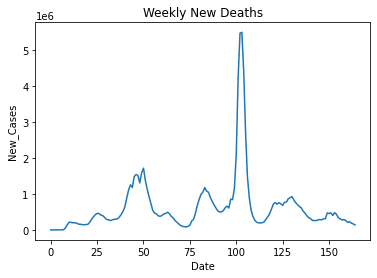

In [6]:
# make a graph of cases of COVID in weeks
df_case['New_Cases'].plot()

plt.xlabel('Date')
plt.ylabel('New_Cases')
plt.title('Weekly New Deaths')

plt.show()

#### Step 2: Building dataframe by reading the inforamtion from `covid_death_data.html`

##### 1) Trends in Number of COVID-19 Deaths in the US Reported to CDC (The text in the next markdown cell is from our proposal)

(a)	This data set obtained from the CDC website, which contains the weekly number of new COVID-19 cases in the United States from January 29th, 2020 to March 22nd, 2023 (present). 

(b)	Link: https://covid.cdc.gov/covid-data-tracker/#trends_totaldeaths_select_00

(c)	This database consists of 166 rows, with each row representing a week. 

(d)	The database contains 4 columns.

<center>

|Variable Name|	Variable Introduction|	Variable Type|
|:----------:|:-------------:|:------:|
|Geography	|Region name|	String|
|Date	|Start date of the week (including month, day, and year)	|String|
|Weekly Deaths	|Newly reported COVID-19 deaths for the week|	Int|
|New Historic Deaths|	Confirmed deaths not from current week but reported during this week|	Int|

</center>

(e)	In this file, the Independent value is: Geography and Date

(f)	The Dependent value is: Weekly Deaths and New Historic Deaths


##### 2) Parsing the data

In [7]:
path = "data/Covid-Data/covid_death_data.html"
htmlparser = etree.HTMLParser()
tree = etree.parse(path, parser = htmlparser)
root = tree.getroot()

We use `path` to locate `covid_death_data.html`, and then the downloaded `HTML` file was parsed using `Etree`. Finally, the root of this file was saved in the variable `root`.

In [8]:
# find the columns of the table
column_names = root.xpath(".//thead/tr/th/text()") 
column_names

['Geography', 'Date', 'Weekly Deaths', 'New Historic Deaths']

We use `xpath` to find all names of columns in the talbe, and showed them by list of `column_names`.

In [9]:
# Grab the Geography
Geography_values = root.xpath(".//tr/td[position()=1]/text()")

# Grab the Date
Date_values = root.xpath(".//tr/td[position()=2]/text()")

# Grab the Weekly Deaths
Weekly_Deaths_values = root.xpath(".//tr/td[position()=3]/text()")
Weekly_Deaths_values = [item.replace(",", "") for item in Weekly_Deaths_values]
Weekly_Deaths_values = [int(item) for item in Weekly_Deaths_values]

# Grab the New Historic Deaths
New_Historic_Deaths_values = root.xpath(".//tr/td[position()=4]/text()")
New_Historic_Deaths_values = [item.replace(",", "") for item in New_Historic_Deaths_values]
New_Historic_Deaths_values = [int(item) for item in New_Historic_Deaths_values]

We grabed the `Geography`, `Date`, `Weekly Deaths`, and `New Historic Deaths` from the table of `covid_death_data.html` by using `xpath`. All of these data stored in `Geography_values`, `Date_values`, `Weekly_Deaths_values`, and `New_Historic_Deaths_values`.

In [10]:
# build data frame by using DoL
DoL = {'Geography': Geography_values, 'Date': Date_values, 'Weekly Deaths': Weekly_Deaths_values, 'New Historic Deaths': New_Historic_Deaths_values}
df_death = pd.DataFrame(DoL)
month_dict = {
    'Jan': '01',
    'Feb': '02',
    'Mar': '03',
    'Apr': '04',
    'May': '05',
    'Jun': '06',
    'Jul': '07',
    'Aug': '08',
    'Sep': '09',
    'Oct': '10',
    'Nov': '11',
    'Dec': '12'
}

df_death['New_Deaths'] = df_death['Weekly Deaths'] - df_death['New Historic Deaths']
df_death['Date']=df_death['Date'].apply(lambda x: x.strip()[-4:])+'-'+df_death['Date'].str[:3].apply(lambda x: month_dict[x])+'-'+df_death['Date'].apply(lambda x: x.strip()[-8:-6].strip())
df_death.loc[df_death['New_Deaths'] < 0, 'New_Deaths'] = df_death['Weekly Deaths']

df_death = df_death.drop(['Geography', 'Weekly Deaths', 'New Historic Deaths'], axis=1)
df_death

,Date,New_Deaths
0,2020-01-29,0
1,2020-02-5,0
2,2020-02-12,0
3,2020-02-19,0
4,2020-02-26,0
...,...,...
160,2023-02-22,2317
161,2023-03-1,2198
162,2023-03-8,2083
163,2023-03-15,1815


We build a dictionary of list to store all of those data, and used `pandas` to convert the DoL into the above data frame `df2`. We also split the `Date` in into `Year`, `Month`, and `Day`.

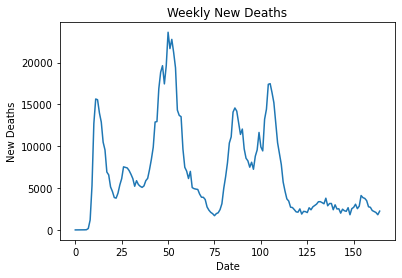

In [11]:
# make a graph of deaths of COVID in weeks
df_death['New_Deaths'].plot()

plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.title('Weekly New Deaths')

plt.show()

#### Step 3: Building dataframe by combining the inforamtion from `df_case` and `df_death`.

In [12]:
df_covid = pd.merge(df_case, df_death, on="Date")
df_covid

,Date,New_Cases,New_Deaths
0,2020-01-29,6,0
1,2020-02-5,12,0
2,2020-02-12,13,0
3,2020-02-19,16,0
4,2020-02-26,27,0
...,...,...,...
160,2023-02-22,207919,2317
161,2023-03-1,229210,2198
162,2023-03-8,187206,2083
163,2023-03-15,167057,1815


We used `merge` to comdine `df_case` and `df_death` together making a final datafrme of COVID data.

### Part C: Making the Dataframes of the Information from `CSV` files of stocks' data

#### a) US Stock Dataset (The text in the next markdown cell is from our proposal)

(a)	The second dataset we will be using is based on the Global Industry Classification Standard (GICS), which is a classification system for industries developed jointly by Morgan Stanley Capital International (MSCI) and Standard & Poor's (S&P) in 1999. 

(b)	This system divides all companies into 11 different industries, and for each industry, we will analyze the stock information of three top companies.

(c)	Link: https://www.kaggle.com/datasets/footballjoe789/us-stock-dataset

(d)	As the data package is too large (8GB) and contains daily US stock market information for each publicly listed company, we will only need to analyze the US stock market performance of the 33 selected companies.

(e)	This database consists of 33 CSV files, each containing information on a company's US stock market performance for each trading day from its initial public offering to March 24th, 2023. Each CSV file contains 8 columns.

|Variable Name|	Variable Introduction|	Variable Type|
|:----------:|:-------------:|:------:|
|Date	|The date of the trading day|	String|
|Open	|The opening price of the stock on the trading day	|Float|
|High	|The highest price of the stock on the trading day|	Float|
|Low	|The lowest price of the stock on the trading day	|Float|
|Close	|The last price at which a stock trades during a regular trading session|	Float|
|Volume	|The number of shares traded in a particular stock, index, or other investment over the trading day	|Float|
|Dividends	|A payment to shareholders that consists of additional shares rather than cash	|Float|
|Stock Splits	|The number of shares of that company increases|	Float|

(f)	In these files, the Independent value is: Date

(g)	The Dependent value is: Open, High, Low, Close, Volume, Dividends, Stock Splits

(h)	Due to different listing times for each company, the number of rows in the CSV files varies. Below is an introduction to the CSV file data for the companies we have selected in each industry.


#### b) The 33 stocks are the following (The text in the next markdown cell is from our proposal):

* Information Technology

	* AAPL.csv

		o	This CSV file contains the stock information of Apple Inc.

		o	The CSV file has 10661 rows and 8 columns.

	* MSFT.csv

		o	This CSV file contains the stock information of Microsoft Corp.

		o	The CSV file has 9335 rows and 8 columns.

	* AMZN.csv 

		o	This CSV file contains the stock information of Amazon.com, Inc.

		o	The CSV file has 6509 rows and 8 columns.

* Financials

	* V.csv

		o	This CSV file contains the stock information of Visa

		o	The CSV file has 3782 rows and 8 columns.

	* JPM.csv

		o	This CSV file contains the stock information of JPMorgan Chase

		o	The CSV file has 10849 rows and 8 columns.

	* C.csv

		o	This CSV file contains the stock information of Citigroup Inc

		o	The CSV file has 11658 rows and 8 columns.

* Healthcare

	* JNJ.csv

		o	This CSV file contains the stock information of Johnson & Johnson

		o	The CSV file has 15414 rows and 8 columns.

	* MRNA.csv

		o	This CSV file contains the stock information of Moderna

		o	The CSV file has 1082 rows and 8 columns.

	* BNTX.csv

		o	This CSV file contains the stock information of BioNTech SE – ADR

		o	The CSV file has 871 rows and 8 columns.

* Consumer Discretionary

	* QSR.csv

		o	This CSV file contains the stock information of Restaurant Brands International Inc

		o	The CSV file has 2086 rows and 8 columns.

	* MAR.csv

		o	This CSV file contains the stock information of Marriott

		o	The CSV file has 6295 rows and 8 columns.

	* NKE.csv

		o	This CSV file contains the stock information of Nike Inc

		o	The CSV file has 10669 rows and 8 columns.

* Industries

	* UPS.csv

		o	This CSV file contains the stock information of UPS

		o	The CSV file has 5881 rows and 8 columns.

	* UAL.csv

		o	This CSV file contains the stock information of United Airlines

		o	The CSV file has 4314 rows and 8 columns.

	* CAT.csv

		o	This CSV file contains the stock information of Caterpillar Inc.

		o	The CSV file has 15414 rows and 8 columns.

* Communication Services

	* NFLX.csv

		o	This CSV file contains the stock information of Netflix

		o	The CSV file has 5247 rows and 8 columns.

	* ZM.csv

		o	This CSV file contains the stock information of Zoom

		o	The CSV file has 992 rows and 8 columns.

	* T.csv

		o	This CSV file contains the stock information of AT&T Inc.

		o	The CSV file has 9917 rows and 8 columns.

* Consumer Staples

	* KO.csv

		o	This CSV file contains the stock information of The Coca-Cola Company

		o	The CSV file has 15414 rows and 8 columns.

	* PG.csv

		o	This CSV file contains the stock information of Procter & Gamble Co

		o	The CSV file has 15414 rows and 8 columns.

	* UL.csv

		o	This CSV file contains the stock information of Unilever plc

		o	The CSV file has 10843 rows and 8 columns.

* Energy

	* XOM.csv

		o	This CSV file contains the stock information of Exxon Mobil Corporation

		o	The CSV file has 15414 rows and 8 columns.

	* CVX.csv

		o	This CSV file contains the stock information of Chevron Corporation

		o	The CSV file has 15414 rows and 8 columns.

	* SHEL.csv

		o	This CSV file contains the stock information of Shell plc

		o	The CSV file has 7151 rows and 8 columns.

* Real Estate

	* AMT.csv

		o	This CSV file contains the stock information of American Tower Corporation

		o	The CSV file has 6311 rows and 8 columns.

	* PLD.csv
	
		o	This CSV file contains the stock information of Prologis, Inc

		o	The CSV file has 6376 rows and 8 columns.

	* CCI.csv

		o	This CSV file contains the stock information of Crown Castle International Corp.

		o	The CSV file has 6192 rows and 8 columns.

* Materials

	* DD.csv

		o	This CSV file contains the stock information of DuPont de Nemours, Inc.

		o	This CSV file has 12815 rows and 8 columns.

	* BHP.csv

		o	This CSV file contains the stock information of BHP Group Limited

		o	This CSV file has 10849 rows and 8 columns.

	* SHW.csv

		o	This CSV file contains the stock information of The Sherwin-Williams Company

		o	The CSV file has 10849 rows and 8 columns.

* Utilities

	* SO.csv

		o	This CSV file contains the stock information of The Southern Company

		o	The CSV file has 10396 rows and 8 columns.

	* ED.csv

		o	This CSV file contains the stock information of Consolidated Edison, Inc.

		o	The CSV file has 15414 rows and 8 columns.

	* AEP.csv

		o	This CSV file contains the stock information of American Electric Power Company, Inc.

		o	The CSV file has 15414 rows and 8 columns.



#### Step 1: Build a function to convert data into appropriate data types

In [13]:
def data1(df):
    ''' 
    Input: The unprocessed dataframe "df".
    
    Output: The processed dataframe "df_final" containing information about the company's stock after the year 2020.
    '''
    # build readable data based on original columns and convert their datatypes
    df['Date'] = df['Date'].str[:10]
    df['Year'] = df['Date'].str[:4].astype(int)
    df['Open_Price']=df['Open'].astype(float).round(3)
    df['Close_Price']=df['Close'].astype(float).round(3)


    # drop all original columns

    df.drop('Open', axis=1, inplace=True)
    df.drop('Close', axis=1, inplace=True)
    df.drop('High', axis=1, inplace=True)
    df.drop('Low', axis=1, inplace=True)
    df.drop('Volume', axis=1, inplace=True)
    df.drop('Dividends', axis=1, inplace=True)
    df.drop('Stock Splits', axis=1, inplace=True)

    # only left the information after year of 2020
    df_final = df[df['Year'] >= 2020]
    df_final.drop('Year', axis=1, inplace=True)
    return df_final

We convert the data into appropriate data types. For the original `Date` column, we split it into three columns, `Year`, `Month`, and `Day`, with `integer` as data type. Then we convert all reamaining columns, `Day`, `Open_Price`, `High_Price`, `Low_Price`, `Close_Price`, and `Stock_Volume`, into `float` as the data type.

We droped all original columns and replaced them by those new column with appropriate data types.

Finally, we only left the data after year of 2020 which is the year that COVID-19 pandemic began in the United States.

#### Step 2: Build a dictionary to store the data from csv files

In [14]:
# read all file into a ductionary
folder_path = "data/Stock"
dfs={}
company_list={}
company_list['Company_Code']=[]
company_list['Industry']=[]
# using for loop, read each folders contained csv files
for folder_name in os.listdir(folder_path):
    folder = os.path.join(folder_path, folder_name)
    if os.path.isdir(folder):

        # using for loop, read each csv files in each folder
        for file_name in os.listdir(folder):

                # build a path to each csv file
                file = os.path.join(folder, file_name)
                if os.path.isfile(file):

                    # read file into lines by using 'open'
                    with open(file, 'r') as f:
                        csv_lines = [line.strip() for line in f.readlines()]

                        # make sure what are columns in the csv file
                        columns = csv_lines[0].split(',')

                        # store the data body into 'data'
                        data = [row.split(',') for row in csv_lines[1:]]

                        # build data frame with pandas
                        df = pd.DataFrame(data, columns=columns)

                        # store the dataframe into the built dictionary
                        file_name=file_name[:-4]
                        dfs[file_name] = data1(df)

                dfs[file_name]['Company_Code']=file_name
                dfs[file_name]=dfs[file_name].melt(id_vars=['Date','Company_Code'],value_vars=['Open_Price','Close_Price'],var_name='Open_Close',value_name='Stock_Price')
                company_list['Company_Code'].append(file_name)
                company_list['Industry'].append(folder_name)

c:\Users\17404\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-14-f706e9c0af0e>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs[file_name]['Company_Code']=file_name
c:\Users\17404\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return

We built a dictionary, `dfs`, to store all data from those `csv` files. We use for loops to find each `csv` file, and `open` it with reading each line of those `csv` files. We store the names of columns in `columns` and all rows in `data`. Then we use `pandas` to convert the data into a data frame. Finally, we store those data frames into the `dfs` with their stock codes.

#### Step 3: Show an example of dataframes in the dictionary

In [15]:
# give an example of dataframes we stored in the dictionary
dfs["NFLX"]

,Date,Company_Code,Open_Close,Stock_Price
0,2020-01-02,NFLX,Open_Price,326.10
1,2020-01-03,NFLX,Open_Price,326.78
2,2020-01-06,NFLX,Open_Price,323.12
3,2020-01-07,NFLX,Open_Price,336.47
4,2020-01-08,NFLX,Open_Price,331.49
...,...,...,...,...
1621,2023-03-20,NFLX,Close_Price,305.13
1622,2023-03-21,NFLX,Close_Price,305.79
1623,2023-03-22,NFLX,Close_Price,293.90
1624,2023-03-23,NFLX,Close_Price,320.37


This is an example of dataframes we stored in the dictionary. By using the stock of Netflix, `NFLX`, we can directly find the data frame transfered from the stock `csv` file.

In [16]:
df_company_list=pd.DataFrame(company_list)
df_company_list

,Company_Code,Industry
0,NFLX,Communication_Services
1,T,Communication_Services
2,ZM,Communication_Services
3,MAR,Consumer_Discretionary
4,NKE,Consumer_Discretionary
5,QSR,Consumer_Discretionary
6,KO,Consumer_Staples
7,PG,Consumer_Staples
8,UL,Consumer_Staples
9,CVX,Energy


By `df_company_list`, we can find the `Company_Code` and `Industry` them belong

#### Step 4: Give a summary about the shape of each data frame we stored in the dictionaty

In [17]:
# give a brief summary about the shape of each data frame we stored in the dictionaty
num=1
for file_name, df in dfs.items():
    print('No.',num)
    print("Name of Data Frame: ", file_name)
    num_rows = df.shape[0]
    num_cols = df.shape[1]
    print("Number of Row:",num_rows)
    print("Number of Column:",num_cols)
    num+=1 

No. 1
Name of Data Frame:  NFLX
Number of Row: 1626
Number of Column: 4
No. 2
Name of Data Frame:  T
Number of Row: 1626
Number of Column: 4
No. 3
Name of Data Frame:  ZM
Number of Row: 1626
Number of Column: 4
No. 4
Name of Data Frame:  MAR
Number of Row: 1626
Number of Column: 4
No. 5
Name of Data Frame:  NKE
Number of Row: 1626
Number of Column: 4
No. 6
Name of Data Frame:  QSR
Number of Row: 1626
Number of Column: 4
No. 7
Name of Data Frame:  KO
Number of Row: 1626
Number of Column: 4
No. 8
Name of Data Frame:  PG
Number of Row: 1626
Number of Column: 4
No. 9
Name of Data Frame:  UL
Number of Row: 1626
Number of Column: 4
No. 10
Name of Data Frame:  CVX
Number of Row: 1626
Number of Column: 4
No. 11
Name of Data Frame:  SHEL
Number of Row: 1626
Number of Column: 4
No. 12
Name of Data Frame:  XOM
Number of Row: 1626
Number of Column: 4
No. 13
Name of Data Frame:  C
Number of Row: 1626
Number of Column: 4
No. 14
Name of Data Frame:  JPM
Number of Row: 1626
Number of Column: 4
No. 15


To show the summary of all dataframes in the dictionary, we printed the sheap of those dataframes one by one. Each of them have a unique stock code, and all of them have 813 rows and 8 columns.

### Part D: Creating Database by the information from `HTML` anf `CSV` files

####  a) Describing our database design:

 For COVID-19 data, there will be one entity which is table named by `covid_case_death`. For the `covid_case_death` table, the independent value is `Date`, and the dependent values are `New_cases` and `New_deaths`. 

 For each stock in the list of 33 stocks we choosed to study, We can combine those 33 stocks into a single talbe as `stock`. For the `stock` table, the independent values are `Date`, `Company_Code`, and `Open_Close`, and the dependent value is `Stock_Price`.

 For the industry information, we build a table called `company_list`. This table record the raltion between `Company_Code` and `Industry`. The independent value is `Company_Code`, and the dependent value is `Industry`. 

#### b) How our database design adheres to principles of good DB design:

We removed some less important data from the original document and retained the more critical data. For example, in the stock table, we only leave the opening and closing prices for comparison and comparison to obtain the volatility of the stock. The other data has not been included in our database. This way, we make the table easier to read.

We combined 33 different stock data into a table. This facilitates our data processing. When we need to know the stock data at a certain point in time, we no longer need to frequently switch between different tables to find the required data. Therefore, our data processing efficiency has been improved.

#### c) Challenges faced when storing our data in our SQL database:

We must unify the format of dates in different documents because we found that in the CDC data, the expression of time includes the English abbreviations for each month, such as Jan. Therefore, we need to unify it with the dates in the stock table in a consistent format. This way, we can establish a connection between `covid_case_death`, `company_list`, and `stock` data by standardizing these formats.

####  d) Discussion of relationships between tables:

In the database we have three tables: `covid_case_death`, `stock`, and `company_list`. The relation between `covid_case_death` and `stock` is one-to-many. The relation between `stock`, and `company_list` is many-to-one.

#### e) Build our database:

##### Step 1: Setting of creation of database

In [18]:
def getsqlite_creds(dirname=".",filename="creds.json",source="sqlite"):
    """ Using directory and filename parameters, open a credentials file
        and obtain the two parts needed for a connection string to
        a local provider using the "sqlite" dictionary within
        an outer dictionary.  
        
        Return a scheme and a dbfile
    """
    assert os.path.isfile(os.path.join(dirname, filename))
    with open(os.path.join(dirname, filename)) as f:
        D = json.load(f)
    sqlite = D[source]
    return sqlite["scheme"], sqlite["dbdir"], sqlite["database"]

In [19]:
def buildConnectionString(source="sqlite_book"):
    scheme, dbdir, database = getsqlite_creds(source=source)
    template = '{}:///{}/{}.db'
    return template.format(scheme, dbdir, database)

In [20]:
# Build the conection string
cstring = buildConnectionString("sqlite_covid")
print("Connection string:", cstring)

# Connect to the database
engine = sa.create_engine(cstring)
connection = engine.connect()

Connection string: sqlite:///dbfiles/covid.db


We use these function and codes from the HW to connect the `covid.db` database.

##### Step 2: Creating tables in databases

In [21]:
# Write the create-table SQL statement
statement_1 = """
CREATE TABLE IF NOT EXISTS  (covid_case_death
    Date DATE NOT NULL,
    New_Cases INT NOT NULL,
    New_Deaths INT NOT NULL,
    PRIMARY KEY (Date)
)
"""

# Execute the statement
try:
    connection.execute(statement_1)
except sa.exc.SQLAlchemyError as err:
    print("CREATE of stock failed:", str(err))

CREATE of stock failed: (sqlite3.OperationalError) near "(": syntax error
[SQL: 
CREATE TABLE IF NOT EXISTS  (covid_case_death
    Date DATE NOT NULL,
    New_Cases INT NOT NULL,
    New_Deaths INT NOT NULL,
    PRIMARY KEY (Date)
)
]
(Background on this error at: http://sqlalche.me/e/14/e3q8)


We have established a table of `covid_case_death`. It includes `New_Cases` and `New_Deaths` used to represent weekly cases and deaths number in the USA, and the `Date` used to represent dates. We have set the `Date` as the primary keys.

In [22]:
df_covid.to_sql("covid_case_death", con=connection, if_exists="append", index=False)

This statement populate the table `covid_case_death` in `covid` database.

In [23]:
# Write the create-table SQL statement
statement_2 = """
CREATE TABLE IF NOT EXISTS stock (
    Date DATE NOT NULL,
    Company_Code VARCHAR(64),
    Open_Close	VARCHAR(64),
    Stock_Price FLOAT NOT NULL,
    PRIMARY KEY (Date,Company_Code,Open_Close)
)
"""

# Execute the statement
try:
    connection.execute(statement_2)
except sa.exc.SQLAlchemyError as err:
    print("CREATE of stock failed:", str(err))

We have established a table of `stock`. It includes `Date`, `Open_Price`, `Close_Price`, `Company_Code`, and `Industry`. We have set the `Date`, `Company_Code`, and `Open_Close` as the primary keys.

In [24]:
company_code=[]
for file_name, df in dfs.items():
    company_code.append(file_name)
company_code

for i in company_code:
    dfs[i].to_sql("stock", con=connection, if_exists="append", index=False)
    

This statement populate the table `stock` in `covid` database.

In [25]:
# Write the create-table SQL statement
statement_3 = """
CREATE TABLE IF NOT EXISTS company_list (
    Company_Code VARCHAR(64),
    Industry VARCHAR(64),
    PRIMARY KEY (Company_Code)
)
"""

# Execute the statement
try:
    connection.execute(statement_3)
except sa.exc.SQLAlchemyError as err:
    print("CREATE of stock failed:", str(err))

We have established a table of `company_list`. It shows the relation between each company and its industry. We have set the `Company_Code` as the primary keys.

In [26]:
#df_company_list
df_company_list.to_sql("company_list", con=connection, if_exists="append", index=False)
    

This statement populate the table `company_list` in `covid` database.

In [27]:
# Close the connection!
try:
    connection.close()
except:
    pass
del engine

This statement close the connection.